# Multilayer Perceptron in PyTorch

**|| Jonty Sinai ||**

In this notebook I explore creating a barebones multilayer perceptron (MLP) using PyTorch. I'll create useful functions providing an interface for testing the MLP on two classic (and low compute) datasets, namely MNIST and CIFAR-10

In [1]:
%matplotlib inline

import os
import random

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
from torchvision import transforms

import matplotlib.pyplot as plt


HOME = os.environ['AI_HOME']
ROOT = os.path.join(HOME, 'artificial_neural_networks')
DATA = os.path.join(ROOT, 'data')
MNIST = os.path.join(DATA, 'mnist')
CIFAR10 = os.path.join(DATA, 'cifar10')

random.seed(1901)
np.random.seed(1901)
torch.manual_seed(1901)

## Simple MLP

The simplest MLP has 1 hidden layer. By convention, this is known as a **2-layer MLP**. 

<br/>
<img src="./assets/mlp.png" width="538">
<br/>
source: [Sungtae An, Georgia Tech](https://www.cc.gatech.edu/~san37/post/dlhc-fnn/)



The MNIST and CIFAR10 datasets have different dimensionality, so we will use specify a `size` argument for the size of the first layer.

> **Note:** Typically the final output layer for an MLP classifier will pass through a _softmax_ nonlinearity. PyTorch however does not require the final output softmax function in the neural network module if `CrossEntropyLoss` is used which combines the `LogSoftmax` layer with `NLLLoss` (negative log-likelihood loss).

In [2]:
class MLP(nn.Module):
    
    def __init__(self, num_features, num_hidden_units, num_classes):
        super().__init__()
        self.hidden_layer = nn.Linear(num_features, num_hidden_units)
        self.output_layer = nn.Linear(num_hidden_units, num_classes)
        
    def forward(self, x):
        a = F.relu(self.hidden_layer(x))
        y = self.output_layer(a)
        return y

### Test Case:

In [3]:
mlp = MLP(10, 20, 2)
print(mlp)

MLP(
  (hidden_layer): Linear(in_features=10, out_features=20, bias=True)
  (output_layer): Linear(in_features=20, out_features=2, bias=True)
)


In [4]:
x = torch.randn(5, 10)

y = mlp(x)
print(y)

tensor([[ 0.5602,  0.1049],
        [-0.2771,  0.2300],
        [-0.2079, -0.0459],
        [-0.3734,  0.2108],
        [-0.1725,  0.1221]], grad_fn=<AddmmBackward>)


## MNIST

MNIST is considered the `"Hello World"` of machine learning, so let's go. `torchvision` conveniently includes a dataloader for MNIST. The dataloader will load the MNIST as `PIL` images which need to be transformed to tensors, so they can be inputted into the MLP. Furthermore, these tensors need to be normalised. For MNIST, the mean and standard deviation are known to be 0.1307 and 0.3081 respectively. 

In [5]:
mnist_transforms = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Normalize((0.1307,), (0.3081,))]  # note that we normalise by rank-1 tensors
                )

mnist_trainset = torchvision.datasets.MNIST(root=MNIST, train=True, download=True, transform=mnist_transforms)
mnist_testset = torchvision.datasets.MNIST(root=MNIST, train=False, transform=mnist_transforms)

Now that we have our MNIST dataset, we need dataloaders to instruct PyTorch how to iterate over the dataset during each epoch.

In [6]:
mnist_trainloader = torch.utils.data.DataLoader(mnist_trainset, batch_size=10, shuffle=True, num_workers=2)
mnist_testloader = torch.utils.data.DataLoader(mnist_testset, batch_size=10, shuffle=False, num_workers=2)

In [7]:
classes = tuple(f"{n}" for n in range(10))
print(classes)

('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')


### Data Preview

It is worthwhile getting a feel for the MNIST data - both as images and as tensors!

MNIST images are `28x28` black and white images. To use feed them as input to an MLP, we need to unroll each image into a 28*28 = 784 long vector. However we have to make sure to get the tensor dimensions right for the MLP's hidden layer.

In [8]:
data_iter = iter(mnist_trainloader)
images, labels = next(data_iter)  # remember that the batch size is 10, so this will contain 10 images

print(images.size())

torch.Size([10, 1, 28, 28])


We will use the following helper function to display MNIST images:

In [9]:
def imshow(img):
    img = img * 0.3081 + 0.1307     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

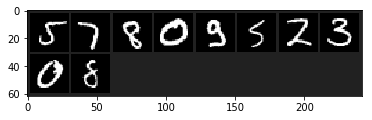

In [10]:
imshow(torchvision.utils.make_grid(images))

To feed into the MLP we will unroll the input as follows:

In [11]:
input_ = images.view(-1, 784)  # -1 tells PyTorch to infer the other dimensions, in this case just batch size
print(input_.size())

torch.Size([10, 784])


## Training for MNIST

Now we will define a generic training loop for the MLP which we can use for both MNIST and CIFAR-10. We will use cross-entropy loss and stochastic gradient descent with momentum.

In [30]:
def train_mlp(mlp, training_data, input_size, learning_rate, momentum, num_epochs):
    
    cross_entropy = nn.CrossEntropyLoss()
    optimiser = optim.SGD(mlp.parameters(), lr=learning_rate, momentum=momentum)
    
    for epoch in range(num_epochs):
        print(f"Epoch: {epoch + 1} " + "="*80 + ">")
        
        total_loss = 0.0
        for batch_idx, batch in enumerate(training_data):
            images, labels = batch
            
            # zero accumulated gradients
            optimiser.zero_grad()
            
            # unroll images
            input_ = images.view(-1, input_size)
            # forward pass
            output = mlp(input_)
            # backward pass
            loss = cross_entropy(output, labels)
            loss.backward()
            optimiser.step()
            
            total_loss += loss.item()
            # print progress
            
            if (batch_idx + 1) % 1000 == 0:    # print every 1000 mini-batches
                print("[%4d/6000] loss: %.3f" %
                      (batch_idx + 1, total_loss / 1000))
                total_loss = 0.0
                
    print("Finished Training " + "="*71 + ">")

#### Now train

In [31]:
mnist_mlp = MLP(784, 280, 10)
print(mnist_mlp)

MLP(
  (hidden_layer): Linear(in_features=784, out_features=280, bias=True)
  (output_layer): Linear(in_features=280, out_features=10, bias=True)
)


In [32]:
train_mlp(mnist_mlp, mnist_trainloader, 784, learning_rate=0.001, momentum=0.9, num_epochs=3)

Epoch: 1 ================================================================================>
[1000/6000] loss: 0.603
[2000/6000] loss: 0.294
[3000/6000] loss: 0.264
[4000/6000] loss: 0.212
[5000/6000] loss: 0.197
[6000/6000] loss: 0.190
Epoch: 2 ================================================================================>
[1000/6000] loss: 0.151
[2000/6000] loss: 0.133
[3000/6000] loss: 0.132
[4000/6000] loss: 0.128
[5000/6000] loss: 0.129
[6000/6000] loss: 0.116
Epoch: 3 ================================================================================>
[1000/6000] loss: 0.095
[2000/6000] loss: 0.085
[3000/6000] loss: 0.099
[4000/6000] loss: 0.089
[5000/6000] loss: 0.098
[6000/6000] loss: 0.083
Finished Training =======================================================================>


## Evaluating on MNIST

Now we will evaluate the MLP - this will be useful for comparing it with other more sophisticated models.

Once again we will start by getting a visual feel for how the model compares to the groundtruth labels.

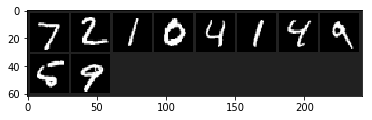

Groundtruth:      7     2     1     0     4     1     4     9     5     9


In [37]:
data_iter = iter(mnist_testloader)
images, labels = data_iter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('Groundtruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(10)))

In [36]:
input_ = images.view(-1, 784)
outputs = mnist_mlp(input_)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(10)))

Predicted:      7     2     1     0     4     1     4     9     6     9


In [40]:
def evaluate_mlp(mlp, test_data, input_size):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_data:
            images, truth = data
            input_ = images.view(-1, input_size)
            output = mlp(input_)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of a simple MLP on the 10000 test images: %d %%' % (100 * correct / total))

In [41]:
evaluate_mlp(mnist_mlp, mnist_testloader, 784)

Accuracy of a simple MLP on the 10000 test images: 90 %


Hello world. In the future we will try to beat 90% by being smart and lean.